<a href="https://colab.research.google.com/github/NidaNabi/ESRGAN/blob/main/ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
from torchsummary import summary
import torch.optim as optim
from torchvision import models, datasets
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook,tqdm
import cv2
import torchvision.utils as vutils
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def downloadSampling(img):
    image = np.array(img)
    image_blur = cv2.resize(image,(64,64),cv2.INTER_CUBIC)
    new_image = Image.fromarray(image_blur)
    return new_image

In [ ]:
HR_transform = transforms.Compose([
                                 transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
LR_transform = transforms.Compose([
                                   transforms.Resize((256,256)),
                                   transforms.Lambda(downloadSampling),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle datasets download -d badasstechie/celebahq-resized-256x256

 99% 281M/283M [00:14<00:00, 25.4MB/s]
100% 283M/283M [00:14<00:00, 20.8MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [ ]:
!unzip celebahq-resized-256x256.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba_hq_256/25000.jpg  
  inflating: celeba_hq_256/25001.jpg  
  inflating: celeba_hq_256/25002.jpg  
  inflating: celeba_hq_256/25003.jpg  
  inflating: celeba_hq_256/25004.jpg  
  inflating: celeba_hq_256/25005.jpg  
  inflating: celeba_hq_256/25006.jpg  
  inflating: celeba_hq_256/25007.jpg  
  inflating: celeba_hq_256/25008.jpg  
  inflating: celeba_hq_256/25009.jpg  
  inflating: celeba_hq_256/25010.jpg  
  inflating: celeba_hq_256/25011.jpg  
  inflating: celeba_hq_256/25012.jpg  
  inflating: celeba_hq_256/25013.jpg  
  inflating: celeba_hq_256/25014.jpg  
  inflating: celeba_hq_256/25015.jpg  
  inflating: celeba_hq_256/25016.jpg  
  inflating: celeba_hq_256/25017.jpg  
  inflating: celeba_hq_256/25018.jpg  
  inflating: celeba_hq_256/25019.jpg  
  inflating: celeba_hq_256/25020.jpg  
  inflating: celeba_hq_256/25021.jpg  
  inflating: celeba_hq_256/25022.jpg  
  inflating: celeba_hq_256/25023.jpg  
  inflating: 

In [ ]:
#LR_train_dataset = datasets.CelebA(root = "celebA",transform = LR_transform, download = True)
LR_train_dataset = datasets.ImageFolder(root = "/content/img",transform = LR_transform)
LR_train_dataloader = DataLoader(LR_train_dataset, batch_size = 4, num_workers = 4)

In [ ]:
#HR_train_dataset = datasets.CelebA(root = "celebA",transform = HR_transform, download = True)
HR_train_dataset = datasets.ImageFolder(root = "/content/img",transform = HR_transform)
HR_train_dataloader = DataLoader(HR_train_dataset, batch_size = 4, num_workers = 4 )

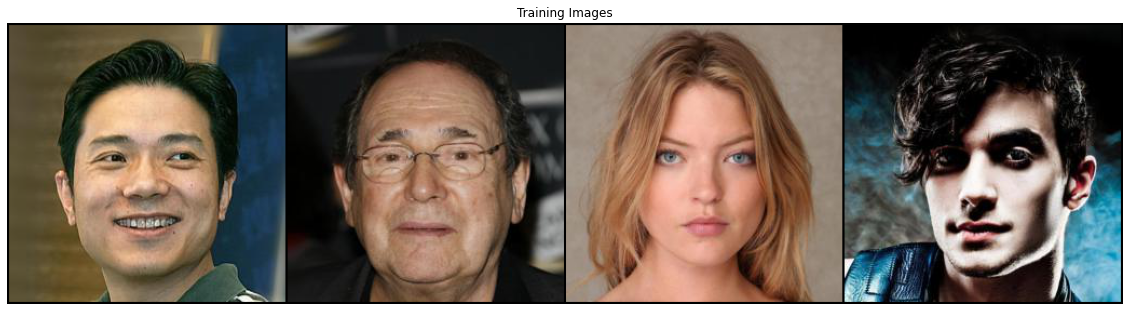

In [ ]:
HR_batch = next(iter(HR_train_dataloader))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(HR_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

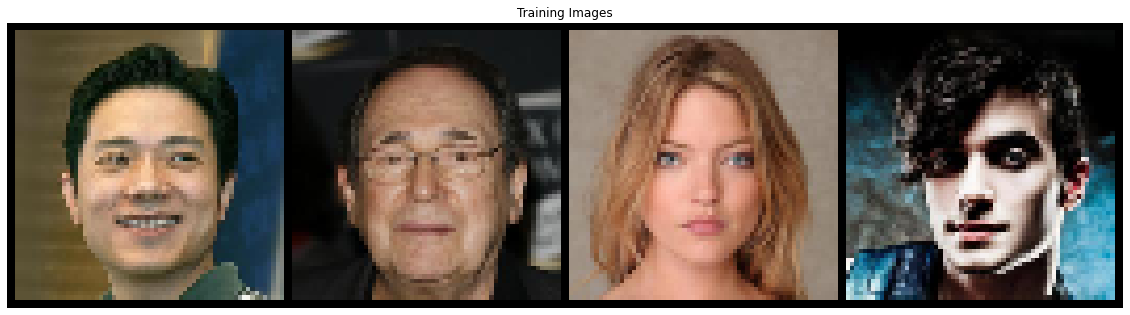

In [ ]:
LR_batch = next(iter(LR_train_dataloader))
#LR_batch = LR_batch.select(range(10000))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(LR_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
vgg = models.vgg19(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
class ResidualDenseBlock(n.Module):
    def __init__(self,in_channel = 64,inc_channel = 32, beta = 0.2):
        super().__init__()
        self.conv1 = n.Conv2d(in_channel, inc_channel, 3, 1, 1)
        self.conv2 = n.Conv2d(in_channel + inc_channel, inc_channel, 3, 1, 1)
        self.conv3 = n.Conv2d(in_channel + 2 * inc_channel, inc_channel, 3, 1, 1)
        self.conv4 = n.Conv2d(in_channel + 3 * inc_channel, inc_channel, 3, 1, 1)
        self.conv5 = n.Conv2d(in_channel + 4 * inc_channel,  in_channel, 3, 1, 1)
        self.lrelu = n.LeakyReLU()
        self.b = beta
        
    def forward(self, x):
        block1 = self.lrelu(self.conv1(x))
        block2 = self.lrelu(self.conv2(torch.cat((block1, x), dim = 1)))
        block3 = self.lrelu(self.conv3(torch.cat((block2, block1, x), dim = 1)))
        block4 = self.lrelu(self.conv4(torch.cat((block3, block2, block1, x), dim = 1)))
        out = self.conv5(torch.cat((block4, block3, block2, block1, x), dim = 1))
        
        return x + self.b * out
            

In [ ]:
class ResidualInResidualDenseBlock(n.Module):
    def __init__(self, in_channel = 64, out_channel = 32, beta = 0.2):
        super().__init__()
        self.RDB = ResidualDenseBlock(in_channel, out_channel)
        self.b = beta
    
    def forward(self, x):
        out = self.RDB(x)
        out = self.RDB(out)
        out = self.RDB(out)
        
        return x + self.b * out
        

In [ ]:
class Generator(n.Module):
    def __init__(self,in_channel = 3, out_channel = 3, noRRDBBlock = 23):
        super().__init__()   
        self.conv1 = n.Conv2d(3, 64, 3, 1, 1)

        RRDB = ResidualInResidualDenseBlock()
        RRDB_layer = []
        for i in range(noRRDBBlock):
            RRDB_layer.append(RRDB)
        self.RRDB_block =  n.Sequential(*RRDB_layer)

        self.RRDB_conv2 = n.Conv2d(64, 64, 3, 1, 1)
        self.upconv = n.Conv2d(64, 64, 3, 1, 1)

        self.out_conv = n.Conv2d(64, 3, 3, 1, 1)
    
    def forward(self, x):
        first_conv = self.conv1(x)
        RRDB_full_block = torch.add(self.RRDB_conv2(self.RRDB_block(first_conv)),first_conv)
        upconv_block1 = self.upconv(f.interpolate(RRDB_full_block, scale_factor = 2))
        upconv_block2 = self.upconv(f.interpolate(upconv_block1, scale_factor = 2))
        out = self.out_conv(upconv_block2)
        
        return out
        
    
    

In [ ]:
gen = Generator().to(device)
# summary(gen,(3,64,64))

In [ ]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8))
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9

In [ ]:
disc = Discriminator().to(device)

In [ ]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0002)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0002)

In [ ]:
class Losses():
    def __init__(self):
        super().__init__()
        self.disc_losss = n.BCEWithLogitsLoss()
        self.gen_losss = n.BCEWithLogitsLoss()
        self.vgg_loss = n.MSELoss()
        self.mse_loss = n.MSELoss()
        self.lamda = 0.005
        self.eeta = 0.02 
        
    def calculateLoss(self,discriminator, generator,LR_image, HR_image):

        disc_optimizer.zero_grad()
        generated_output = generator(LR_image.to(device).float())
        fake_data = generated_output.clone()
        fake_label = discriminator(fake_data)

        
        HR_image_tensor = HR_image.to(device).float()
        real_data = HR_image_tensor.clone()
        real_label = discriminator(real_data)
        
        relativistic_d1_loss = self.disc_losss((real_label - torch.mean(fake_label)), torch.ones_like(real_label, dtype = torch.float))
        relativistic_d2_loss = self.disc_losss((fake_label - torch.mean(real_label)), torch.zeros_like(fake_label, dtype = torch.float))      

        d_loss = (relativistic_d1_loss + relativistic_d2_loss) / 2
        d_loss.backward(retain_graph = True)
        disc_optimizer.step()

        fake_label_ = discriminator(generated_output)
        real_label_ = discriminator(real_data)
        gen_optimizer.zero_grad()

        g_real_loss = self.gen_losss((fake_label_ - torch.mean(real_label_)), torch.ones_like(fake_label_, dtype = torch.float))
        g_fake_loss = self.gen_losss((real_label_ - torch.mean(fake_label_)), torch.zeros_like(fake_label_, dtype = torch.float))
        g_loss = (g_real_loss + g_fake_loss) / 2
        
        v_loss = self.vgg_loss(vgg.features[:6](generated_output),vgg.features[:6](real_data))
        m_loss = self.mse_loss(generated_output,real_data)
        generator_loss = self.lamda * g_loss + v_loss + self.eeta * m_loss
        generator_loss.backward()
        gen_optimizer.step()

        return d_loss,generator_loss
        

In [ ]:
def loadImages(imageList,path):
    images=[]
    for image in (imageList):
        img = cv2.imread(os.path.join(path,image))
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

In [ ]:
epochs = 2
weight_file = "ESRPT_weights"
out_path = "out"

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

test_image_path = os.path.join(os.getcwd(),"test_celeb_data")


In [ ]:
images = os.listdir(test_image_path)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [ ]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(test_image_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
    
    imagearrayPT = np.moveaxis(imagearray,3,1)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    out = np.clip(out,0,1)
    
    return out

In [ ]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(os.getcwd(),"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

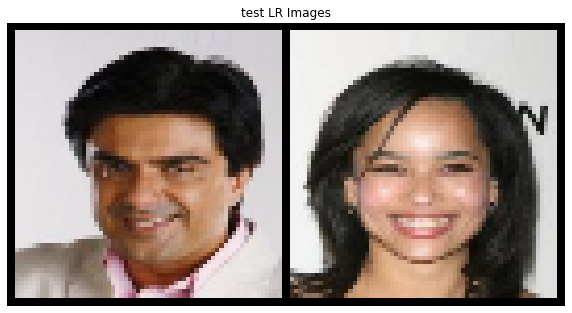

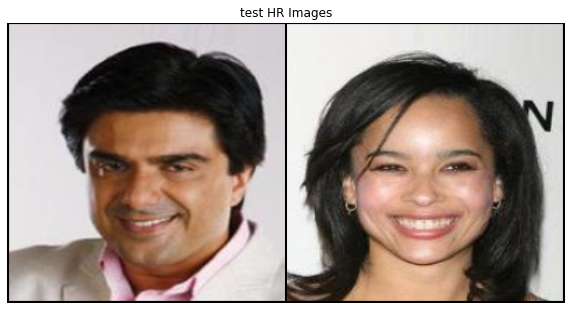

In [ ]:
LR_test = datasets.ImageFolder(root = "/content/test1",transform = LR_transform)
LR_test = DataLoader(LR_test, batch_size = 4, num_workers = 4)
LR_batch = next(iter(LR_test))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("test LR Images")
plt.imshow(np.transpose(vutils.make_grid(LR_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))
HR_test = datasets.ImageFolder(root = "/content/test1",transform = HR_transform)
HR_test = DataLoader(HR_test, batch_size = 4, num_workers = 4 )
HR_batch = next(iter(HR_test))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("test HR Images")
plt.imshow(np.transpose(vutils.make_grid(HR_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch ::::  1  d_loss ::: 0.07726533472218709  g_loss :::1.403241877901554


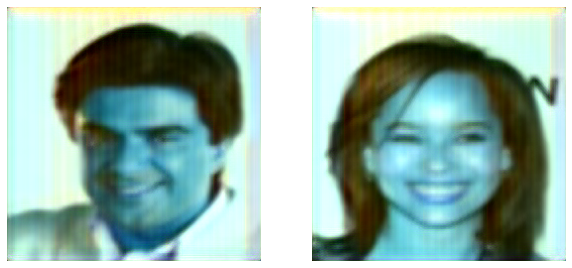

  0%|          | 0/7500 [00:00<?, ?it/s]

In [ ]:
for epoch in (range(epochs)):
    dloss_list=[]
    gloss_list=[]
    
    for data_idx ,(HR_data, LR_data) in tqdm_notebook(enumerate(zip(HR_train_dataloader,LR_train_dataloader)), total = len(LR_train_dataloader)):
        HR_data, LR_data = HR_data[0], LR_data[0]
        
        
        disc_loss, gen_loss = Losses().calculateLoss(disc, gen, LR_data, HR_data)
        dloss_list.append(disc_loss.item())
        gloss_list.append(gen_loss.item())
        # print(disc_loss, gen_loss)
        torch.cuda.empty_cache()
#         if(data_idx == 125):
#             break

    print("Epoch ::::  "+str(epoch+1)+"  d_loss ::: "+str(np.mean(dloss_list))+"  g_loss :::"+str(np.mean(gloss_list)))

    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"ESR"+str(epoch+1)+".pth"))
        
        out_images = imagePostProcess(images[-2:],os.path.join(weight_file,"ESR"+str(epoch+1)+".pth"))
        show_samples(out_images)